In [ ]:
import pymatching
import numpy as np
import pickle
import matplotlib.pyplot as plt
from ldpc import bposd_decoder
from beliefmatching import detector_error_model_to_check_matrices

from heavy_hex_floquet_codes import Floquet_HHX, Double_Floquet_HHX
from heavy_hex_color_code import ColorCode

# Leakage reducing measurements on the Floquet code

## detector slice diagram

In [3]:
leakage_reduction_rounds = 4
hex_rows,hex_cols = 6,3
num_cycles = 4

code = Floquet_HHX(hex_rows=hex_rows, hex_cols=hex_cols, log_obs = "X", num_cycles = num_cycles, gate_error = 0.01,id_error = 0.01,RO_error = 0.01, LR_method=leakage_reduction_rounds)
print(code.d)

3


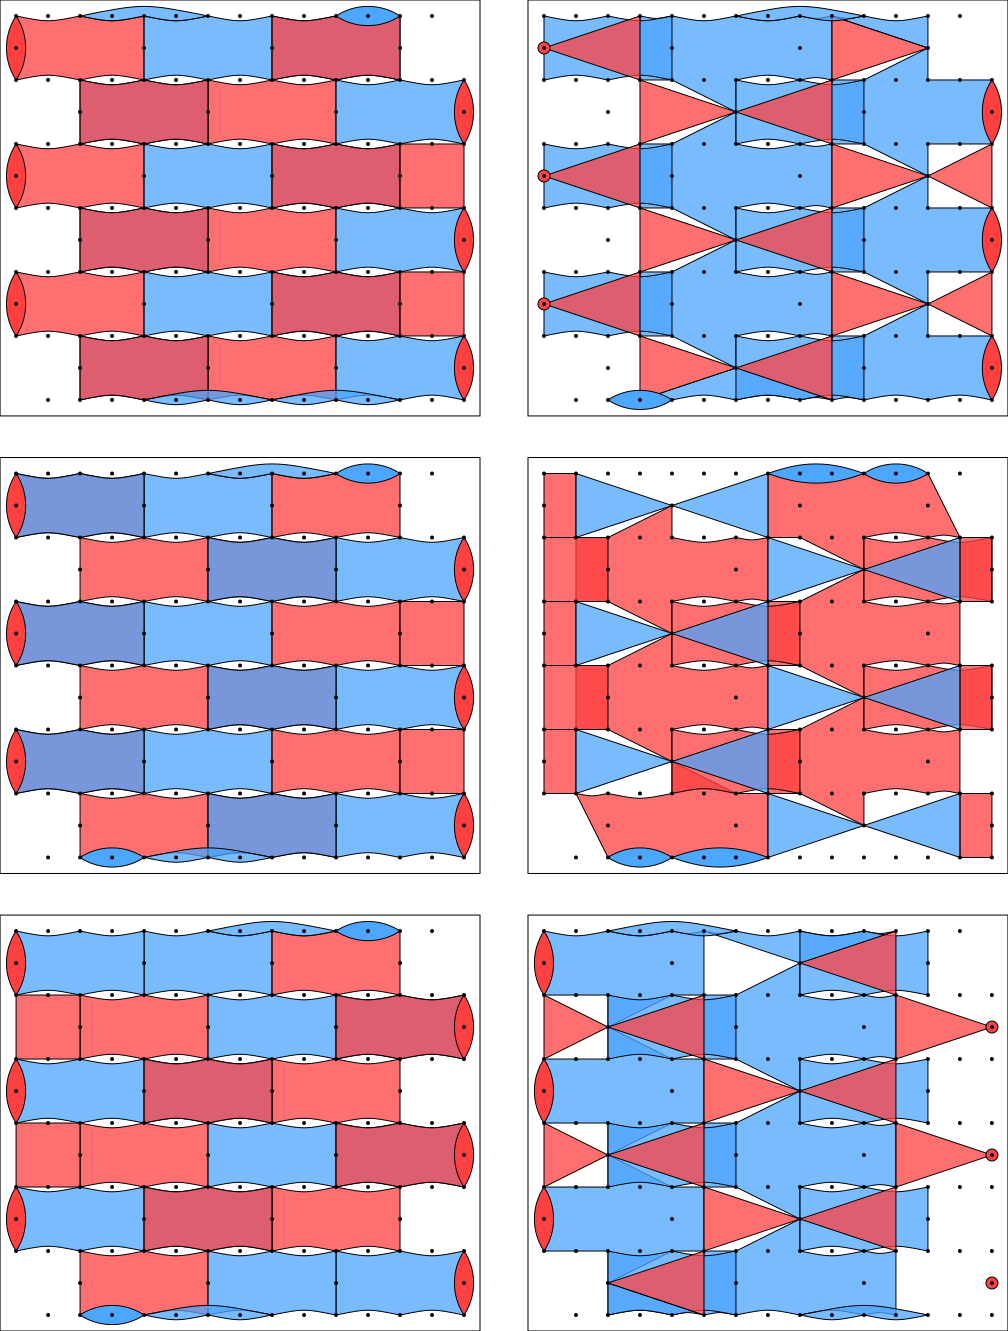

In [4]:
stim_circuit = code.stim_circuit.without_noise()
det_list = [f"D{det_ind}" for det_ind in range(stim_circuit.num_detectors)]

det_slice = stim_circuit.without_noise().diagram('detslice-svg',tick=range(18,24),filter_coords=det_list,rows=3)

det_slice

## threshold plot

In [ ]:
num_shots = 100_000
shot_batch = 1_000
prec = 0.1 # in terms of sqrt(#failures)

LRU = 2
log_obs = "Z"

d_list = []
error_list = np.logspace(-3.5,-2.3,7)
LF_list_d = []
LF_err_list_d = []

for hex_cols in range(3,9,3):
    LF_list = []
    LF_err_list = []
    for error in error_list:
        code = Floquet_HHX(hex_rows=2*hex_cols, hex_cols=hex_cols, log_obs = log_obs, num_cycles = int(hex_cols/3), gate_error = error,id_error = error,RO_error = error, LR_method = LRU)
        stim_circuit = code.stim_circuit
        
        m = pymatching.Matching(stim_circuit.detector_error_model(decompose_errors = True))
        log_fails = 0
        shots = 0
        num_shots2 = 0
        while num_shots2<num_shots and log_fails<=1/prec*np.sqrt(log_fails):
            num_shots2+=shot_batch
            samples = stim_circuit.compile_detector_sampler().sample(shot_batch,append_observables=True) 
            for sample in samples:
                raw_logical = sample[-1]
                log_flip = m.decode(sample[:-1])[0]
                log_fails += (raw_logical != log_flip)
        LF_list.append(log_fails/num_shots2)
        LF_err_list.append(np.sqrt(log_fails)/num_shots2)
        print(code.d, error, log_fails/num_shots2)
    d_list.append(code.d)
    LF_list_d.append([code.d,LF_list])
    LF_err_list_d.append([code.d,LF_err_list])

In [ ]:
pth, PLth = 0.003, 0.03

for (d, LF_list),(_, LF_err_list) in zip(LF_list_d,LF_err_list_d):
    plt.fill_between(error_list,np.array(LF_list).flatten()-np.sqrt(np.array(LF_list).flatten()/num_shots),np.array(LF_list).flatten()+np.sqrt(np.array(LF_list).flatten()/num_shots),alpha = 0.3)
    plt.fill_between(error_list,
                     np.array(LF_list).flatten()-np.array(LF_err_list).flatten(),
                     np.array(LF_list).flatten()+np.array(LF_err_list).flatten(),
                     alpha = 0.3)
    plt.plot(error_list,np.array(LF_list).flatten(),  '-',label=r"$d = "+str(d)+r"$")
    if d == max(d_list):
        plt.plot(error_list,PLth*(np.array(error_list)/pth)**np.ceil(d/2), ':', c='gray', label = r"$(p/p_{th})^{\lceil d/2\rceil}$")
    else:
        plt.plot(error_list,PLth*(np.array(error_list)/pth)**np.ceil(d/2), ':', c='gray')

plt.legend()
plt.ylim(1/num_shots)
plt.loglog()
plt.title(r"Floquet code",fontsize = 15, fontfamily='times')
plt.xlabel(r"physical error rate",fontsize = 15, fontfamily='times')
plt.ylabel(r"logical error rate",fontsize = 15, fontfamily='times')
plt.show()

plotting the data for the figures in the paper

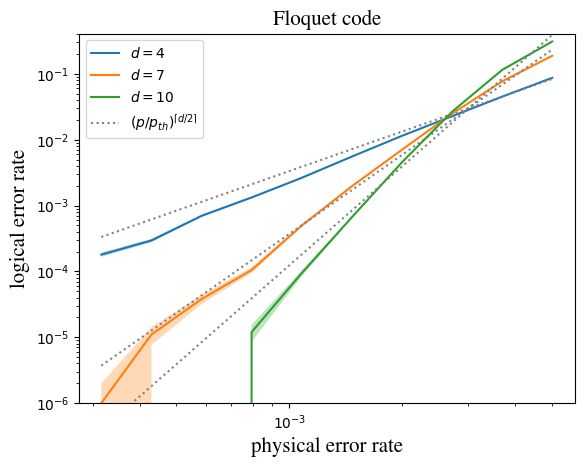

In [13]:
# with open('simulations/Floquet_threshold_logZ_LR0_1M.pkl','rb') as f:
#     d_list,error_list,LF_list_d = pickle.load(f)
# with open('simulations/Floquet_threshold_logZ_LR1_1M.pkl','rb') as f:
#     d_list,error_list,LF_list_d = pickle.load(f)
with open('simulations/Floquet_threshold_logZ_LR2_1M.pkl','rb') as f:
    d_list,error_list,LF_list_d = pickle.load(f)
# with open('simulations/Floquet_threshold_logZ_LR3_1M.pkl','rb') as f:
#     d_list,error_list,LF_list_d = pickle.load(f)
# with open('simulations/Floquet_threshold_logZ_LR4_1M.pkl','rb') as f:
#     d_list,error_list,LF_list_d = pickle.load(f)

pth, PLth = 0.003, 0.03
num_shots = 1e6

for d, LF_list in LF_list_d:
    plt.fill_between(error_list,np.array(LF_list).flatten()-np.sqrt(np.array(LF_list).flatten()/num_shots),np.array(LF_list).flatten()+np.sqrt(np.array(LF_list).flatten()/num_shots),alpha = 0.3)
    plt.plot(error_list,np.array(LF_list).flatten(),  '-',label=r"$d = "+str(d)+r"$")
    if d == max(d_list):
        plt.plot(error_list,PLth*(np.array(error_list)/pth)**np.ceil(d/2), ':', c='gray', label = r"$(p/p_{th})^{\lceil d/2\rceil}$")
    else:
        plt.plot(error_list,PLth*(np.array(error_list)/pth)**np.ceil(d/2), ':', c='gray')

plt.legend()
plt.ylim(1/num_shots)
plt.loglog()
plt.title(r"Floquet code",fontsize = 15, fontfamily='times')
plt.xlabel(r"physical error rate",fontsize = 15, fontfamily='times')
plt.ylabel(r"logical error rate",fontsize = 15, fontfamily='times')
plt.show()

# Double Floquet code

## detector slice diagram

In [7]:
hex_rows,hex_cols = 6,3
num_cycles = 3
dangling_bonds = True

code = Double_Floquet_HHX(hex_rows=hex_rows, hex_cols=hex_cols, log_obs = "X", num_cycles = num_cycles, gate_error = 0.01,id_error = 0.01,RO_error = 0.01,dangling_bonds=dangling_bonds)
print(code.d)

3


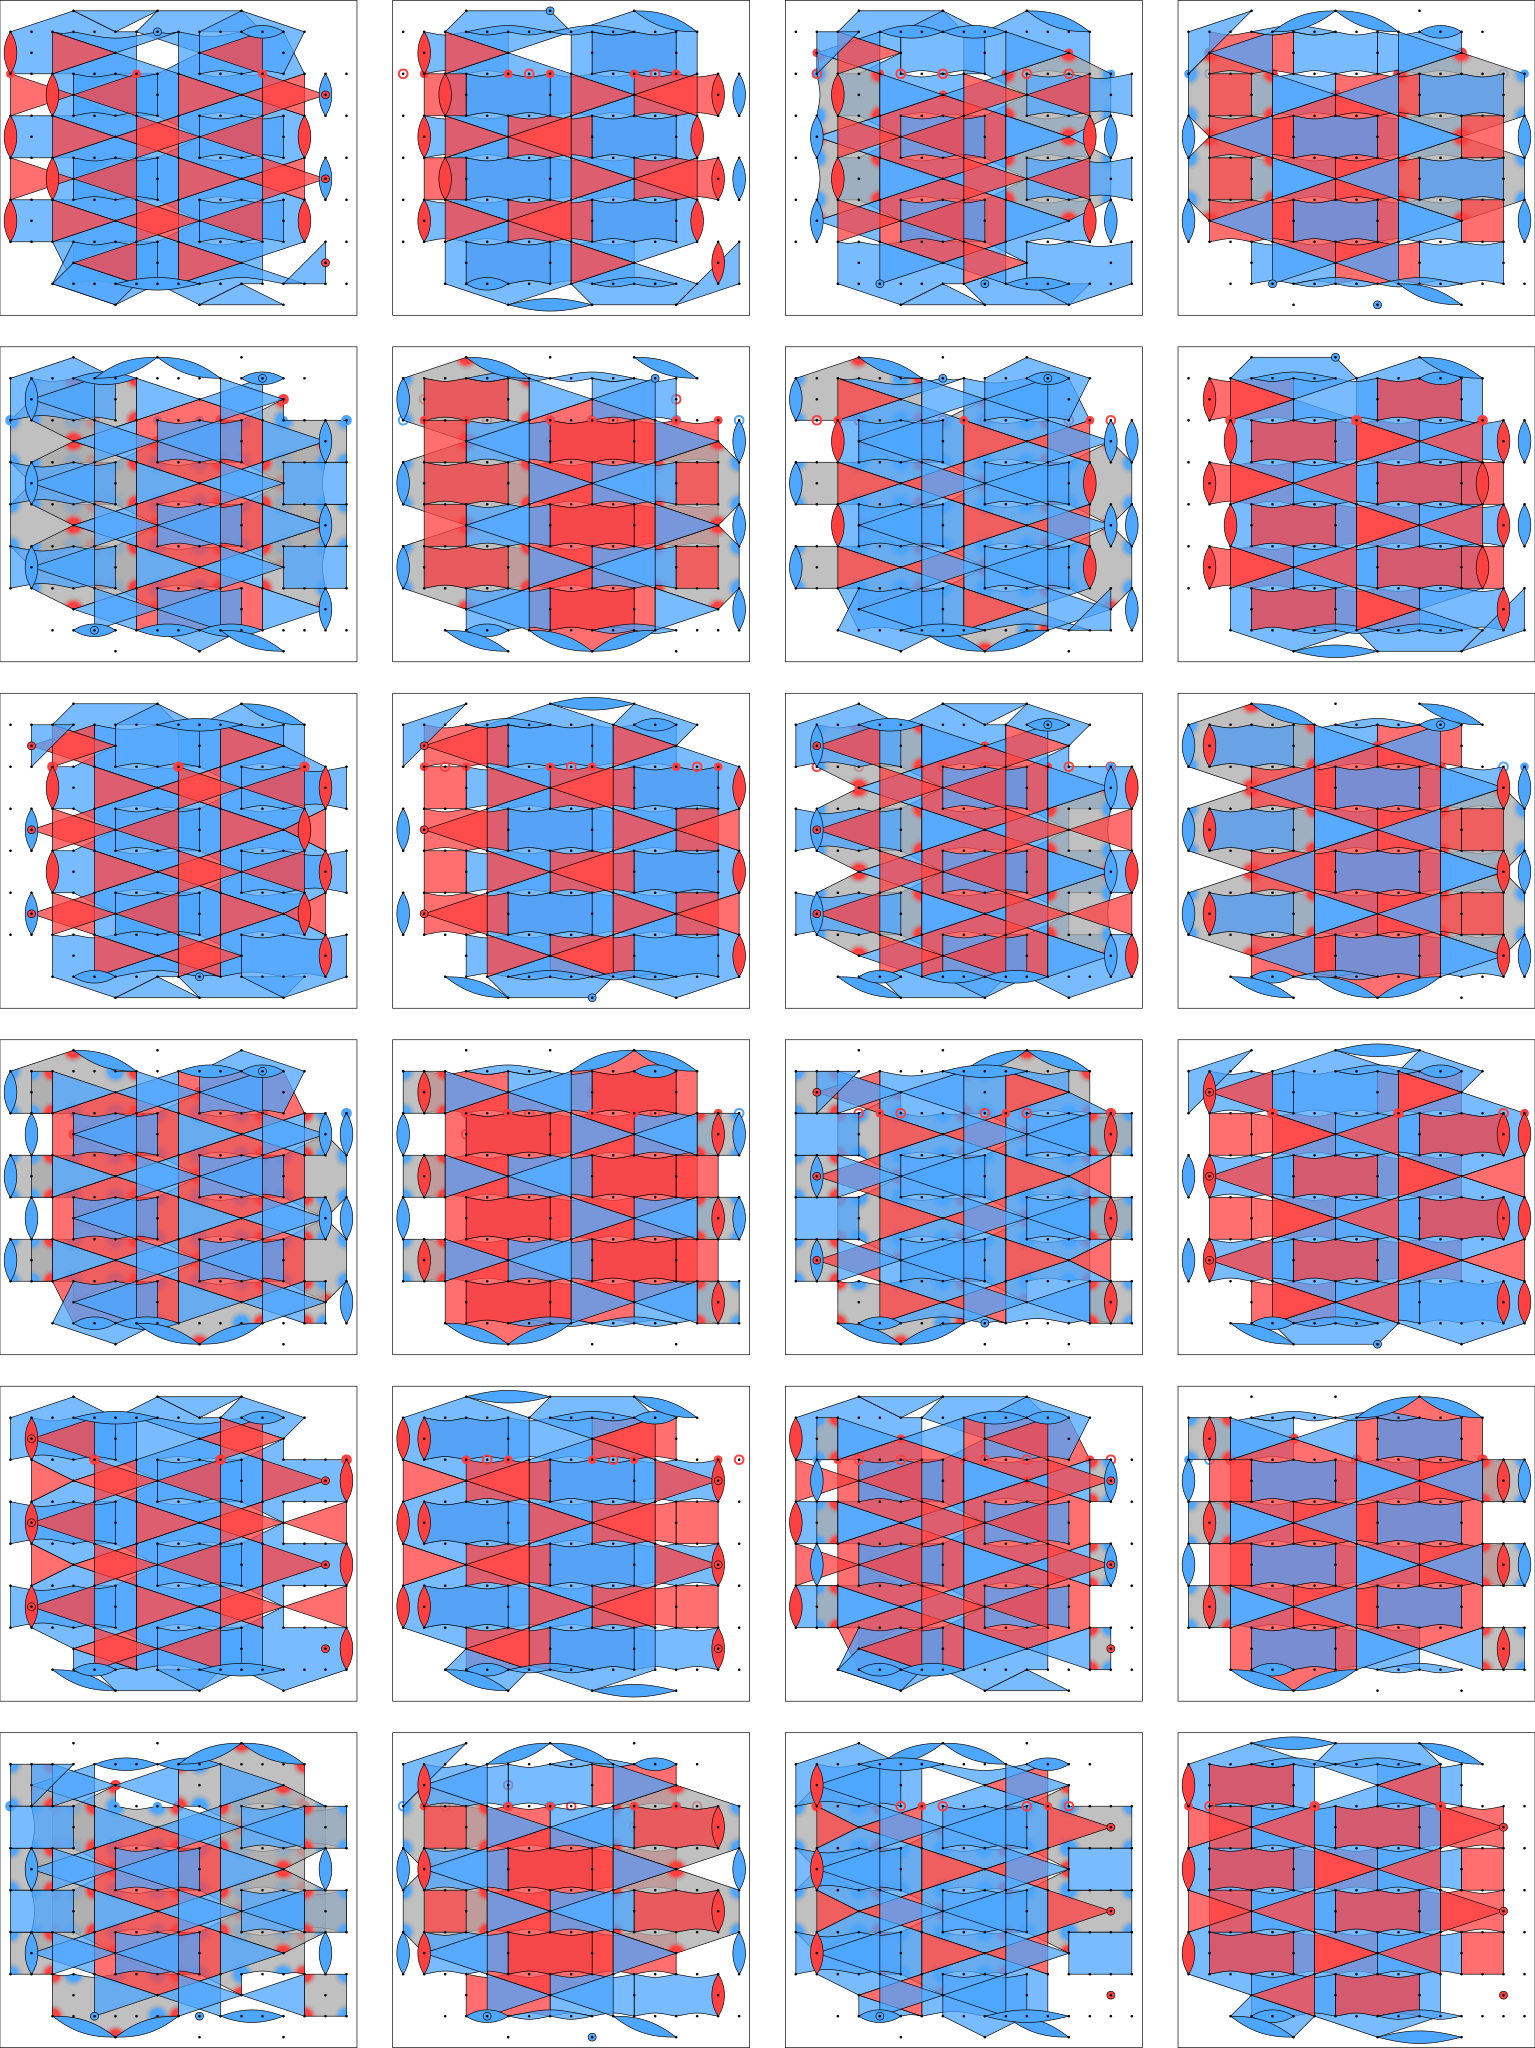

In [8]:
stim_circuit = code.stim_circuit.without_noise()
tick = 500
det_list = [f"D{det_ind}" for det_ind in range(stim_circuit.num_detectors)]

det_list+=["L0"]

det_slice = stim_circuit.without_noise().diagram('detslice-svg',tick=range(24,48),filter_coords=det_list,rows=6)

det_slice

## threshold plot

In [ ]:
num_shots = 10_000
shot_batch = 100
prec = 0.1

d_list = []
error_list = np.logspace(-3.5,-2.3,5)
LF_list_d = []
LF_err_list_d = []

for hex_cols in range(3,9,3):
    LF_list = []
    LF_err_list = []
    for error in error_list:
        code = Double_Floquet_HHX(hex_rows=2*hex_cols, hex_cols=hex_cols, log_obs = "Z", num_cycles = int(hex_cols/3),
                                  gate_error = error,id_error = error,RO_error = error,dangling_bonds=True)
        stim_circuit = code.stim_circuit
        
        m = pymatching.Matching(stim_circuit.detector_error_model(decompose_errors = True))
        
        log_fails = 0
        shots = 0
        num_shots2 = 0
        while num_shots2<num_shots and log_fails<=1/prec*np.sqrt(log_fails):
            num_shots2+=shot_batch
            samples = stim_circuit.compile_detector_sampler().sample(shot_batch,append_observables=True) 
            for sample in samples:
                raw_logicals = sample[-2:]
                log_flip = m.decode(sample[:-2])
                log_fails += sum((raw_logicals+log_flip)%2)>0 # either of them fails
        LF_list.append(log_fails/num_shots2)
        LF_err_list.append(np.sqrt(log_fails)/num_shots2)
        print(code.d, error, log_fails/num_shots2)
    d_list.append(code.d)
    LF_list_d.append([code.d,LF_list])
    LF_err_list_d.append([code.d,LF_err_list])

In [ ]:
pth, PLth = 0.0018, 0.05

for (d, LF_list),(_, LF_err_list) in zip(LF_list_d,LF_err_list_d):
    plt.fill_between(error_list,
                     np.array(LF_list).flatten()-np.array(LF_err_list).flatten(),
                     np.array(LF_list).flatten()+np.array(LF_err_list).flatten(),
                     alpha = 0.3)
    plt.plot(error_list,np.array(LF_list).flatten(),  '-',label=r"$d = "+str(d)+r"$")
    if d == max(d_list):
        plt.plot(error_list,PLth*(np.array(error_list)/pth)**np.ceil(d/2), ':', c='gray', label = r"$(p/p_{th})^{\lceil d/2\rceil}$")
    else:
        plt.plot(error_list,PLth*(np.array(error_list)/pth)**np.ceil(d/2), ':', c='gray')

plt.legend()
plt.loglog()
plt.title(r"Double Floquet code",fontsize = 15, fontfamily='times')
plt.xlabel(r"physical error rate",fontsize = 15, fontfamily='times')
plt.ylabel(r"logical error rate",fontsize = 15, fontfamily='times')
plt.show()

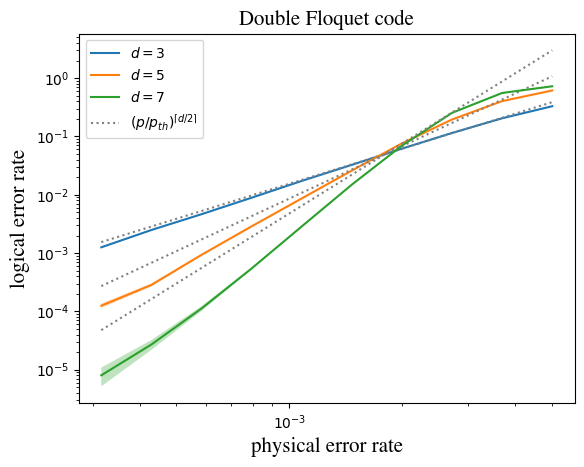

In [14]:
# with open('simulations/Double_Floquet_threshold_dangling_logXX_1M.pkl','rb') as f:
#     d_list, error_list,LF_list_d = pickle.load(f)
with open('simulations/Double_Floquet_threshold_dangling_logZZ_1M.pkl','rb') as f:
    d_list, error_list,LF_list_d = pickle.load(f)

num_shots = 1e6
pth, PLth = 0.0018, 0.05

for d, LF_list in LF_list_d:
    plt.fill_between(error_list,np.array(LF_list).flatten()-np.sqrt(np.array(LF_list).flatten()/num_shots),np.array(LF_list).flatten()+np.sqrt(np.array(LF_list).flatten()/num_shots),alpha = 0.3)
    plt.plot(error_list,np.array(LF_list).flatten(),  '-',label=r"$d = "+str(d)+r"$")
    if d == max(d_list):
        plt.plot(error_list,PLth*(np.array(error_list)/pth)**np.ceil(d/2), ':', c='gray', label = r"$(p/p_{th})^{\lceil d/2\rceil}$")
    else:
        plt.plot(error_list,PLth*(np.array(error_list)/pth)**np.ceil(d/2), ':', c='gray')

plt.legend()
plt.loglog()
plt.title(r"Double Floquet code",fontsize = 15, fontfamily='times')
plt.xlabel(r"physical error rate",fontsize = 15, fontfamily='times')
plt.ylabel(r"logical error rate",fontsize = 15, fontfamily='times')
plt.show()

# Color code

## detector slice diagrams

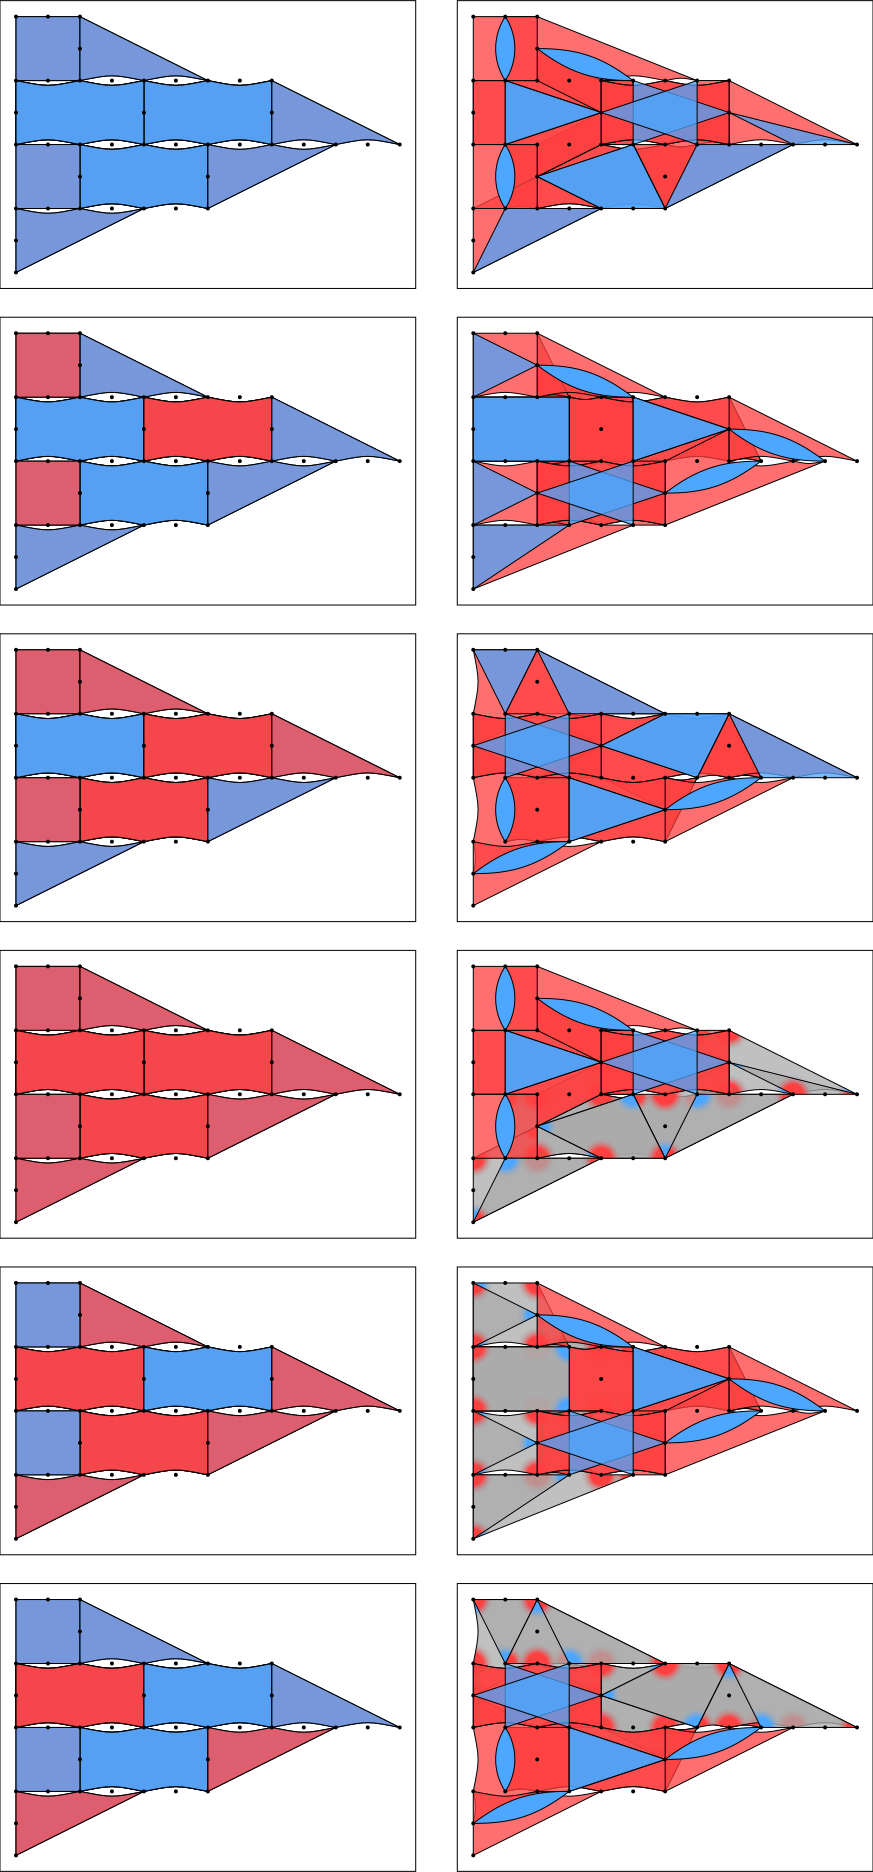

In [4]:
stim_circuit = ColorCode(d=5,num_rounds=3,log_obs = 'X')
# det_slice = stim_circuit.without_noise().diagram('detslice-with-ops-svg',tick=range(2,20),rows=4)
det_slice = stim_circuit.without_noise().diagram('detslice-svg',tick=range(12,24),rows=6)
# det_slice = stim_circuit.without_noise().diagram('detslice-with-ops-svg',tick=range(17,24),rows=3)
det_slice

## threshold plot

Here we use BP-OSD instead of the decision tree decoder, because the former is open sourced. Performance seems to be similar

In [ ]:
num_shots = 100_000
shot_batch = 100
prec = .1


size_list = range(5,12,4)
err_list = np.logspace(-3.5,-2.5,7)
d_list = []
LF_list = []
LF_errlist = []

for size in size_list:
    LF_dlist = []
    LF_errdlist = []
    for error_rate in err_list:
        stim_circuit = ColorCode(d=size,error_rate=error_rate,log_obs='X')
        d = len(stim_circuit.shortest_graphlike_error())
        if error_rate==err_list[0]:
            d_list += [d]
        print(d,error_rate)

        check_mat, log_mat, priors = detector_error_model_to_check_matrices(stim_circuit.detector_error_model(), allow_undecomposed_hyperedges=True)
        decoder = bposd_decoder(check_mat,
                                max_iter=12,
                                channel_probs=priors.tolist(),
                                osd_method="osd_CS",
                                osd_order=10)

        raw_fail = 0
        log_fail = 0
        shots = 0
        while shots<num_shots and np.sqrt(log_fail)>=1/prec*log_fail:
            shots+=shot_batch
            samples = stim_circuit.compile_detector_sampler().sample(shot_batch,append_observables=True)
            for syndrome in samples:
                raw_logical = syndrome[-1]
                raw_fail+=raw_logical
                decoded_error = decoder.decode(syndrome[:-1])
                log_fail += (raw_logical + log_mat@decoded_error)%2
        print('   log_error rate',log_fail/shots, 'shots',shots)
        LF_dlist.append(log_fail[0]/shots)
        LF_errdlist.append(np.sqrt(log_fail[0])/shots)
    LF_list += [LF_dlist]
    LF_errlist += [LF_errdlist]

LF_list = np.array(LF_list)
LF_errlist = np.array(LF_errlist)

In [ ]:
pth = 0.0025
PLth = 0.05
for d,LF_d,LF_err in zip(d_list,LF_list,LF_errlist):
    plt.plot(err_list, LF_d,label=d)
    plt.fill_between(err_list, LF_d-LF_err,LF_d+LF_err,alpha=0.3)
for d,LF_d,LF_err in zip(d_list,LF_list,LF_errlist):
    plt.plot(err_list, PLth*(err_list/pth)**np.ceil(d/2),':',c='black',label=(d==d_list[0])*r'$p^{\lceil d/2 \rceil}$')
plt.legend()
plt.title('switching color code (BP-OSD)')
plt.xlabel('physiscal error rate')
plt.ylabel('logical error rate')
plt.loglog()
plt.show()

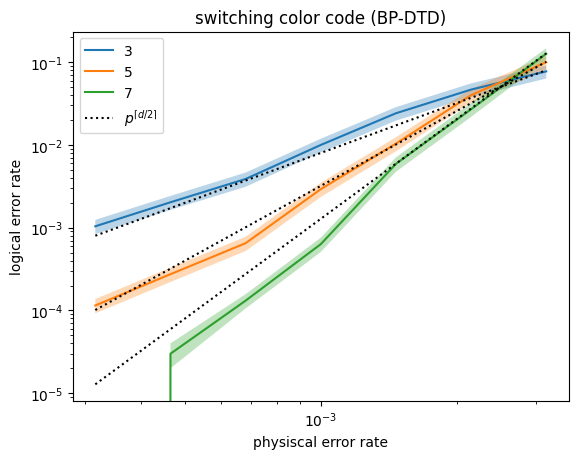

In [16]:
with open('simulations/ColorCode_threshold_logZ_300k.pkl','rb') as f:
    d_list,err_list,LF_list,LF_errlist = pickle.load(f)

pth = 0.0025
PLth = 0.05
for d,LF_d,LF_err in zip(d_list,LF_list,LF_errlist):
    plt.plot(err_list, LF_d,label=d)
    plt.fill_between(err_list, LF_d-LF_err,LF_d+LF_err,alpha=0.3)
for d,LF_d,LF_err in zip(d_list,LF_list,LF_errlist):
    plt.plot(err_list, PLth*(err_list/pth)**np.ceil(d/2),':',c='black',label=(d==d_list[0])*r'$p^{\lceil d/2 \rceil}$')
plt.legend()
plt.title('switching color code (BP-DTD)')
plt.xlabel('physiscal error rate')
plt.ylabel('logical error rate')
plt.loglog()
plt.show()